In [1]:
%load_ext autoreload
%autoreload 2
from etr.auto_import import *
from etr.data.data_loader import load_data

## Data

In [25]:
trade = pd.concat([
    load_data(["2025-05-01", "2025-05-19"], table="MarketTrade", venue="*", symbol="BTCJPY"),
    load_data(["2025-05-01", "2025-05-19"], table="MarketTrade", venue="*", symbol="XBTUSD"),
])
trade["term_amount"] = trade.amount * trade.price / 1e6
trade["latency"] = (trade["timestamp"] - trade.market_created_timestamp).dt.total_seconds() * 1e3

2025-05-18 09:58:21.487|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 67 HDB files, process loading...
100%|██████████| 67/67 [00:00<00:00, 99.75it/s] 
2025-05-18 09:58:22.478|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 17 HDB files, process loading...
100%|██████████| 17/17 [00:00<00:00, 43.77it/s]


In [93]:
rate = pd.concat([
    load_data(["2025-05-01", "2025-05-19"], table="Rate", venue="*", symbol="USDJPY"),
    load_data(["2025-05-01", "2025-05-19"], table="Rate", venue="*", symbol="BTCJPY"),
    load_data(["2025-05-01", "2025-05-19"], table="Rate", venue="*", symbol="XBTUSD"),
])

2025-05-18 14:01:56.747|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 14 HDB files, process loading...
100%|██████████| 14/14 [00:00<00:00, 14.07it/s]
2025-05-18 14:01:58.108|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 67 HDB files, process loading...
100%|██████████| 67/67 [00:03<00:00, 21.49it/s]
2025-05-18 14:02:02.454|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 17 HDB files, process loading...
100%|██████████| 17/17 [00:01<00:00, 10.68it/s]


In [27]:
rate.head(3)

,timestamp,market_created_timestamp,sym,venue,category,best_bid,best_ask,mid_price,misc,universal_id
0,2025-05-01 00:00:00.024862+00:00,2025-05-01 00:00:00.015000+00:00,USDJPY,gmo,websocket,142.978,143.066,143.022,OPEN,c1442b47e96640b5b7db36b1766d8ced
1,2025-05-01 00:00:00.325752+00:00,2025-05-01 00:00:00.317000+00:00,USDJPY,gmo,websocket,142.976,143.064,143.020,OPEN,bcf973f009da4426b55240942ecea07c
2,2025-05-01 00:00:00.627216+00:00,2025-05-01 00:00:00.618000+00:00,USDJPY,gmo,websocket,142.978,143.066,143.022,OPEN,54407e33cd77421a95d9f5aa7fb730ff


In [28]:
trade.head(3)

,timestamp,market_created_timestamp,sym,venue,category,side,price,amount,trade_id,order_ids,misc,universal_id,term_amount,latency
0,2025-05-01 00:00:07.491455+00:00,2025-05-01 00:00:07.431000+00:00,BTCJPY,bitflyer,json-rpc,-1,13500227.0,0.003020,2595104564,JRF20250430-235943-011342_JRF20250501-000007-0...,None,5ea5937d109249a1ae0c5135efe29132,0.040777,60.455
1,2025-05-01 00:00:07.766648+00:00,2025-05-01 00:00:07.701000+00:00,BTCJPY,bitflyer,json-rpc,-1,13500227.0,0.006980,2595104565,JRF20250430-235943-011342_JRF20250501-000007-0...,None,cd6ce955036746359bbd26680ed52f80,0.094225,65.648
2,2025-05-01 00:00:07.767034+00:00,2025-05-01 00:00:07.701000+00:00,BTCJPY,bitflyer,json-rpc,-1,13500224.0,0.027426,2595104566,JRF20250430-235921-015298_JRF20250501-000007-0...,None,aac080fda0304eeca963121985e8614b,0.370256,66.034


---

### best spread

In [9]:
rate["spread"] = (rate.best_ask - rate.best_bid) / rate.mid_price * 1e4

In [15]:
rate.groupby(["venue", "sym"]).spread.describe().sort_values("mean")

count      mean        std           min       25%  \
venue     sym                                                              
coincheck BTCJPY   365424.0  0.412942   1.513676    -21.462884 -0.303792   
bitbank   BTCJPY   146441.0  0.797011   1.212445    -22.150935  0.000731   
gmo       USDJPY  3386117.0  1.061355   2.113948      0.134546  0.137410   
          BTCJPY  1929366.0  2.470783   1.029685      0.000647  1.732312   
bitflyer  BTCJPY  4643759.0  4.039206  43.575368 -20000.000000  3.052985   

                       50%       75%        max  
venue     sym                                    
coincheck BTCJPY  0.531413  1.401103  94.960852  
bitbank   BTCJPY  0.314580  1.236066  26.368904  
gmo       USDJPY  0.139102  0.278991   7.913913  
          BTCJPY  2.419222  3.142473  36.052163  
bitflyer  BTCJPY  4.072164  5.142153  36.183200

In [20]:
rate.groupby(["venue", "sym", rate.timestamp.dt.hour]).spread.median().unstack(level=[0, 1]).style.bar()

In [45]:
v = trade.set_index("market_created_timestamp").groupby(["venue", "sym"]).resample("10min").amount.sum().unstack(level=[0, 1])
c = trade.set_index("market_created_timestamp").groupby(["venue", "sym"]).resample("10min").amount.count().unstack(level=[0, 1])

In [47]:
display(
    "Volume",
    v.describe().T,
    "Count",
    c.describe().T,
)

'Volume'

,,count,mean,std,min,25%,50%,75%,max
venue,sym,,,,,,,,
bitbank,BTCJPY,2448.0,1.406304,2.062795,0.000000,0.282200,0.706200,1.657450,25.414300
bitflyer,BTCJPY,2448.0,5.404590,6.726031,0.000000,1.464762,3.191828,6.894719,117.096104
bitmex,XBTUSD,2448.0,25.140019,33.225679,0.104278,9.834105,15.633411,26.395917,431.858256
coincheck,BTCJPY,2213.0,4.521844,4.954551,0.012680,1.610429,3.109399,5.968454,77.257520
gmo,BTCJPY,2364.0,2.898990,3.503518,0.000000,1.092750,1.936500,3.340000,67.019000


'Count'

,,count,mean,std,min,25%,50%,75%,max
venue,sym,,,,,,,,
bitbank,BTCJPY,2448.0,72.673203,71.841851,0.0,30.0,53.0,92.00,1030.0
bitflyer,BTCJPY,2448.0,208.517565,180.795836,0.0,89.0,156.5,275.00,2702.0
bitmex,XBTUSD,2448.0,450.745098,429.346830,16.0,218.0,330.5,518.25,5189.0
coincheck,BTCJPY,2213.0,213.913692,227.041698,4.0,83.0,154.0,269.00,4126.0
gmo,BTCJPY,2364.0,202.637479,202.844462,0.0,100.0,155.0,242.00,3761.0


---

### Deviation

preprocessing

In [ ]:
# best price
best = rate.set_index("timestamp").groupby(["venue", "sym"])[["best_bid", "best_ask"]].resample("5s").last().unstack(level=[0, 1])
best = best.swaplevel(0, -1, axis=1).swaplevel(0, 1, axis=1)

In [432]:
# traded price
tprice = trade.set_index("market_created_timestamp").groupby(["venue", "sym"]).price.resample("5s", label="right").last().unstack(level=[0, 1])

In [296]:
# exec price
exec_price = trade.set_index("market_created_timestamp").shift(freq="-100ms").groupby(["venue", "sym", "side"]).price.resample("5s").agg(["min", "max"])
exec_price = exec_price.unstack(level=[0, 1, 2]).swaplevel(0, -1, axis=1)
sell = exec_price.loc[:, ix[-1, :, :, "min"]][-1]
sell.columns = ["sell_"+"_".join(c[:1]) for c in sell.columns]

buy = exec_price.loc[:, ix[1, :, :, "max"]][1]
buy.columns = ["buy_"+"_".join(c[:1]) for c in buy.columns]
exec_price = buy.join(sell)

In [274]:
# mid prices
mid = rate.set_index(["timestamp"]).groupby(["venue", "sym"]).mid_price.resample("5s", label="right").last().unstack(level=[0, 1]).ffill()
mid[("bitmex", "XBTJPY")] = mid.bitmex.XBTUSD * mid.gmo.USDJPY
mid = mid.drop([("gmo", "USDJPY"), ("bitmex", "XBTUSD"), ("bitbank", "BTCJPY")], axis=1)
mid.columns = mid.columns.get_level_values(0)
mid = mid.mask(mid.div(mid.rolling("10min").mean()).sub(1).abs().ge(0.03), np.nan).ffill()

In [275]:
# deviation -- from globa mid
global_mid = mid.mean(axis=1).to_frame("mid")
dev = mid.div(global_mid.values).sub(1).mul(1e4)
dev.describe().T

,count,mean,std,min,25%,50%,75%,max
venue,,,,,,,,
bitflyer,293760.0,6.829066,4.561865,-244.078169,3.758966,6.229584,9.765986,33.551730
coincheck,265546.0,9.800640,6.068667,-22.705984,5.583083,10.256276,13.686251,99.895326
gmo,283597.0,-2.238807,5.309921,-18.775856,-5.646302,-2.423351,0.669989,81.468676
bitmex,293760.0,-13.527057,6.312836,-48.547285,-17.586378,-13.362636,-9.286601,64.205771


In [647]:
# deviation MA
freq = "10min"
dev_ma = dev.rolling(freq).mean()
dev_smooth = dev - dev_ma
dev_smooth.describe().T

,count,mean,std,min,25%,50%,75%,max
venue,,,,,,,,
bitflyer,293760.0,-0.000709,2.148136,-249.292324,-0.746465,-0.004249,0.742239,30.420594
coincheck,265546.0,0.000041,1.410942,-22.847955,-0.776376,-0.009416,0.759387,85.523094
gmo,283597.0,0.000321,1.408703,-36.449325,-0.679792,0.005811,0.687606,81.585984
bitmex,293760.0,-0.001118,1.381766,-17.925448,-0.707072,0.000450,0.698021,82.350055


In [748]:
# 10min return
theta = dev_smooth.abs().quantile(q=0.95)
sig = (dev_smooth.abs() > theta).mul(np.sign(dev_smooth)).stack().to_frame("signal").query("signal != 0").mul(-1)
display(
    theta.to_frame().T,
    sig.join(mid.shift(-12*10).div(mid).sub(1).mul(1e4).stack().to_frame("ret_10min")).groupby(["venue", "signal"]).ret_10min.describe()
)

venue,bitflyer,coincheck,gmo,bitmex
0.95,2.503845,2.458993,2.163923,2.328343


count      mean        std         min        25%  \
venue     signal                                                       
bitflyer  -1.0    7442.0 -1.814450  19.821965 -327.243455 -11.401874   
           1.0    7246.0  3.706403  25.552612 -129.488533  -6.835388   
bitmex    -1.0    7077.0 -1.349955  23.204943 -112.667200 -12.954100   
           1.0    7611.0  2.900553  20.968911 -110.931612  -8.047431   
coincheck -1.0    6996.0 -0.809501  17.443089  -80.501870 -10.143380   
           1.0    6282.0  2.426244  20.752323  -94.224363  -7.260966   
gmo       -1.0    7155.0  0.504787  18.616997 -106.552647  -6.537568   
           1.0    7025.0  0.713876  19.169808  -95.555695  -7.432542   

                       50%        75%         max  
venue     signal                                   
bitflyer  -1.0   -1.552796   7.781610  115.337445  
           1.0    3.713384  14.006181  348.381703  
bitmex    -1.0   -0.996630   9.796423  177.347278  
           1.0    2.241600  13.512680  132.806937  
coincheck -1.0   -1.191639   7.850058  115.196989  
           1.0    0.928193  11.446630  121.468514  
gmo       -1.0    0.000000   7.351789  148.252375  
           1.0    0.000000   9.498181  159.724775

- dev := (mid - global_mid)
- dev_ma = Rolling(dev)
- dev_smooth = dev - dev_ma
- dev_smooth > 5bps => short
- dev_smooth < -5bps => long

### Biflyer

In [ ]:
venue = ""
pd.concat([
    ask[venue],
    bid[venue],
    tprice[venue],
], axis=1).iloc[11000:11000+100].plot()

<Axes: >

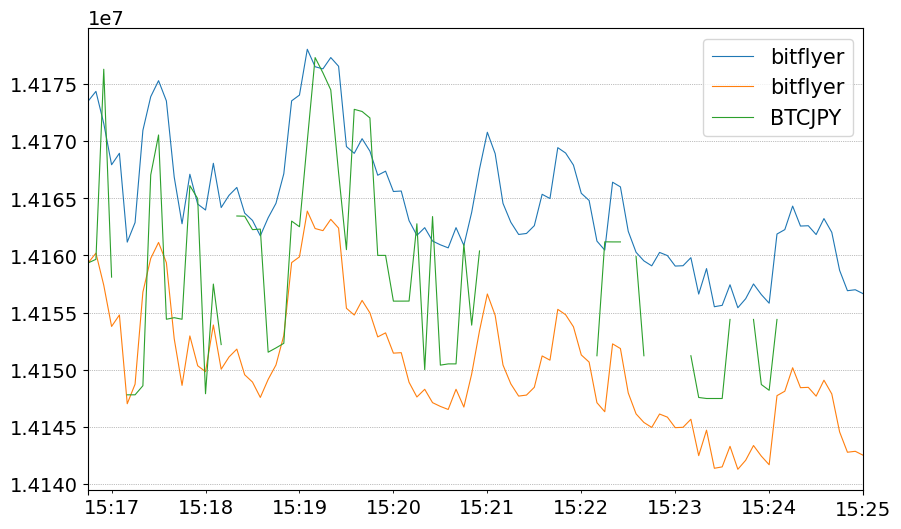

In [741]:
# pricing example
venue == "bitflyer"
offset = 5
ask = (dev_ma + offset).div(1e4).add(1).mul(global_mid.values)
bid = (dev_ma - offset).div(1e4).add(1).mul(global_mid.values)
pd.concat([
    ask[venue],
    bid[venue],
    tprice[venue],
], axis=1).iloc[11000:11000+100].plot()

In [751]:
# concolidate
venue = "bitflyer"
offset = 5
ask = (dev_ma + offset).div(1e4).add(1).mul(global_mid.values)
bid = (dev_ma - offset).div(1e4).add(1).mul(global_mid.values)
data = pd.concat([
    ask[venue].rename("ask"),
    bid[venue].rename("bid"),
    mid[venue].rename("mid"),
    exec_price[[f"buy_{venue}", f"sell_{venue}"]].set_axis(["buy", "sell"], axis=1),
    best[venue].BTCJPY.set_axis(["best_bid", "best_ask"], axis=1),
    dev_ma[venue].to_frame("dev_ma"),
    dev_smooth[venue].to_frame("dev_smooth"),
    global_mid.mid.pct_change().rolling(freq).std().mul(np.sqrt(12 * 1440 * 365) * 100).to_frame("vol"),
    np.sign((global_mid.mid - global_mid.mid.rolling(freq).mean())).rename("ma_sign"),
], axis=1)
# data.head(3)

In [752]:
data.vol.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
vol,293758.0,23.297543,14.168327,2.650787,14.698089,19.780798,27.700236,268.427046


In [753]:
# run simulation
pos = 0
exit_spread = 3
vol_threshold = 30
horizon = 12 * 8
transactions = []
stop_loss = 20
tp_level = 20
for i, (t, row) in tqdm(enumerate(data.iterrows())):
    if pos != 0:
        # LIMIT
        if pos > 0:
            price = row.mid * (1 + exit_spread / 1e4)
            # price = transactions[-1][-2] * (1 + exit_spread / 1e4)  # Profit target pricing
            if price < row.buy:
                pos = 0
                transactions.append([i, t, -1, price, "limit"])
        elif pos < 0:
            price = row.mid * (1 - exit_spread / 1e4)
            # price = transactions[-1][-2] * (1 - exit_spread / 1e4)  # Profit target pricing
            if price > row.sell:
                pos = 0
                transactions.append([i, t, +1, price, "limit"])
        
        # SL
        if pos != 0 and pos * (row.mid / transactions[-1][-2] - 1) * 1e4 < -stop_loss:
            pos = 0
            price = row.best_bid if pos > 0 else row.best_ask
            transactions.append([i, t, pos * -1, price, "sl"])
            
        # TP
        price = row.best_bid if pos > 0 else row.best_ask
        if pos != 0 and pos * (price / transactions[-1][-2] - 1) * 1e4 > tp_level:
            pos = 0
            transactions.append([i, t, pos * -1, price, "tp"])
        
        # HORIZON
        if pos != 0 and transactions[-1][0] + horizon < i:
            pos = 0
            price = row.best_bid if pos > 0 else row.best_ask
            transactions.append([i, t, pos * -1, price, "market"])
    else:
        if row.ask < row.buy and row.vol < vol_threshold and row.dev_ma > 0 and row.ma_sign < 0:
            pos -= 1
            transactions.append([i, t, -1, row.ask, "limit"])
        if row.sell < row.bid and row.vol < vol_threshold and row.dev_ma  < 0 and row.ma_sign > 0:
            pos += 1
            transactions.append([i, t, +1, row.bid, "limit"])
            
# form results table
trs = pd.DataFrame(transactions, columns=["i", "time", "side", "price", "order"])
trs = pd.concat([
    trs.iloc[::2].reset_index(drop=True).rename(lambda x: f"entry_{x}", axis=1),
    trs.iloc[1::2].reset_index(drop=True).rename(lambda x: f"exit_{x}", axis=1),
], axis=1)

trs["pl"] = (trs.exit_price/trs.entry_price).sub(1).mul(1e4).mul(trs.entry_side)

0it [00:00, ?it/s]

In [754]:
trs.pl.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
pl,506.0,2.765772,6.95407,-29.33884,0.175194,4.575342,6.903333,19.886113


<Axes: xlabel='entry_time', ylabel='PNL[%]'>

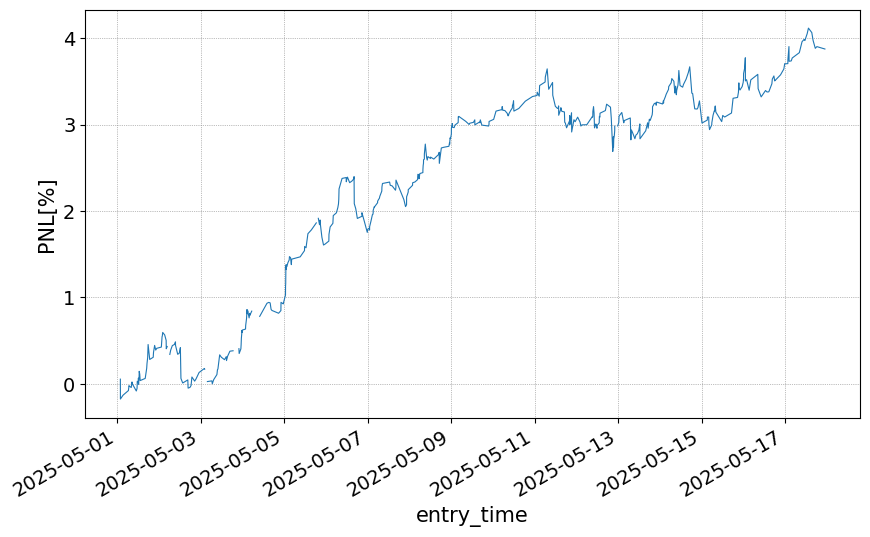

In [770]:
trs.set_index("entry_time").pl.sub(2).div(100).cumsum().plot(ylabel="PNL[%]")

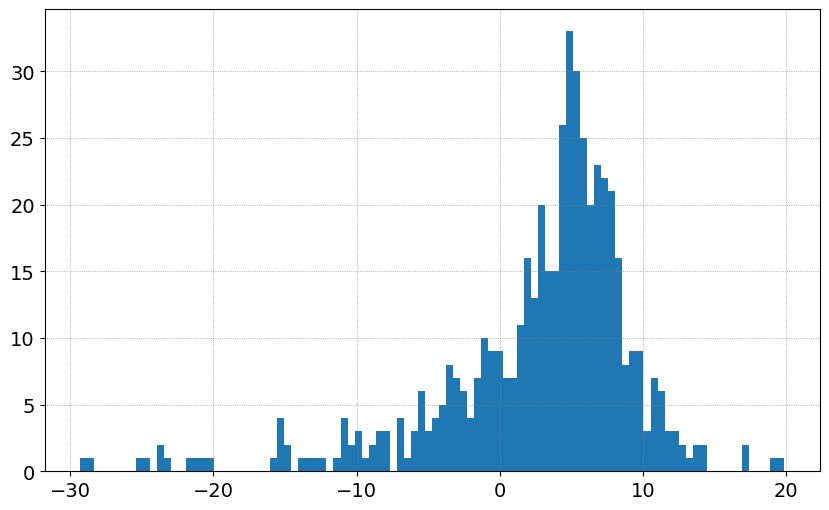

In [755]:
trs.pl.hist(bins=100);

In [756]:
trs.groupby("entry_side").pl.describe()

,count,mean,std,min,25%,50%,75%,max
entry_side,,,,,,,,
-1,493.0,2.685419,6.975322,-29.338840,0.158224,4.548121,6.883002,19.073035
1,13.0,5.813000,5.470568,-1.285841,2.181052,6.435117,7.562248,19.886113


In [757]:
trs.groupby(["entry_order", "exit_order"]).pl.describe()

count       mean       std        min        25%  \
entry_order exit_order                                                     
limit       limit       433.0   4.056948  5.244203 -23.667794   1.979713   
            market       63.0  -1.884386  7.275213 -15.768460  -6.678678   
            sl           10.0 -23.846151  3.213097 -29.338840 -25.229184   

                              50%        75%        max  
entry_order exit_order                                   
limit       limit        4.947910   7.135325  19.886113  
            market      -1.698763   2.668227  13.971551  
            sl         -23.472654 -21.167714 -20.180451

In [758]:
trs.groupby(trs.entry_time.dt.weekday).pl.describe()

,count,mean,std,min,25%,50%,75%,max
entry_time,,,,,,,,
0,72.0,2.884889,6.912680,-25.359072,0.681677,5.022503,7.023949,12.788227
1,61.0,2.736173,7.973015,-29.338840,1.159862,5.245072,7.190460,11.314507
2,67.0,2.703050,7.167775,-28.562937,1.700200,4.763411,6.654964,10.664281
3,97.0,3.249756,6.885417,-23.616497,0.158224,4.716596,7.062575,19.886113
4,81.0,2.170212,6.973286,-24.839519,-1.698181,3.470929,5.778908,14.095019
5,70.0,3.356899,5.526982,-15.016726,1.332312,4.281248,6.730885,17.288283
6,58.0,2.030363,7.452513,-21.595068,-1.500580,3.173671,7.108618,14.338237


In [761]:
trs.groupby(trs.entry_time.dt.hour).pl.describe().style.bar(subset=["mean"])

,count,mean,std,min,25%,50%,75%,max
entry_time,,,,,,,,
0,26.000000,4.754034,6.764078,-23.616497,4.020198,5.683521,7.401393,12.788227
1,28.000000,3.146577,8.148050,-24.839519,2.524761,5.035505,6.646154,14.095019
2,23.000000,4.385986,7.011285,-15.016726,0.195930,5.558036,8.117856,17.288283
3,24.000000,1.282081,5.690342,-12.356206,0.410513,3.136626,5.067392,7.031990
4,21.000000,3.278237,5.609790,-7.729387,-0.269186,4.572690,7.215859,13.971551
5,15.000000,4.046639,3.340390,-2.654716,2.030364,5.137024,6.594728,7.988894
6,18.000000,4.532670,4.087436,-7.163901,2.978868,5.254063,7.211605,10.636216
7,22.000000,3.856726,6.817714,-23.328811,2.543700,5.193975,7.077224,11.047049
8,27.000000,1.549443,7.505263,-21.595068,-0.748969,2.692893,6.585114,8.434109


In [773]:
trs.set_index("entry_time").between_time(datetime.time(22), datetime.time(6)).pl.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
pl,179.0,3.575402,6.179219,-24.839519,1.72147,4.903439,6.783383,17.288283


<Axes: xlabel='entry_time', ylabel='PnL%'>

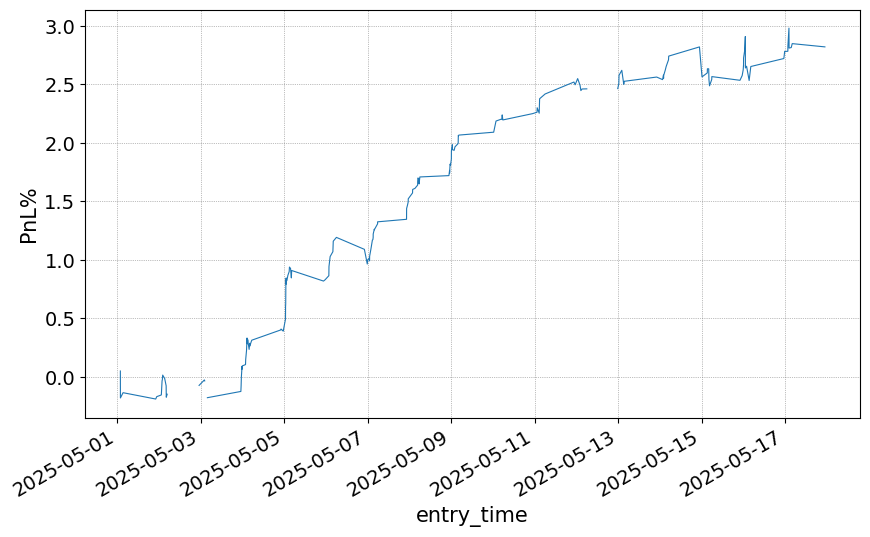

In [774]:
trs.set_index("entry_time").between_time(datetime.time(22), datetime.time(6)).pl.sub(2).cumsum().div(1e2).plot(ylabel="PnL%")

<Axes: ylabel='PnL%'>

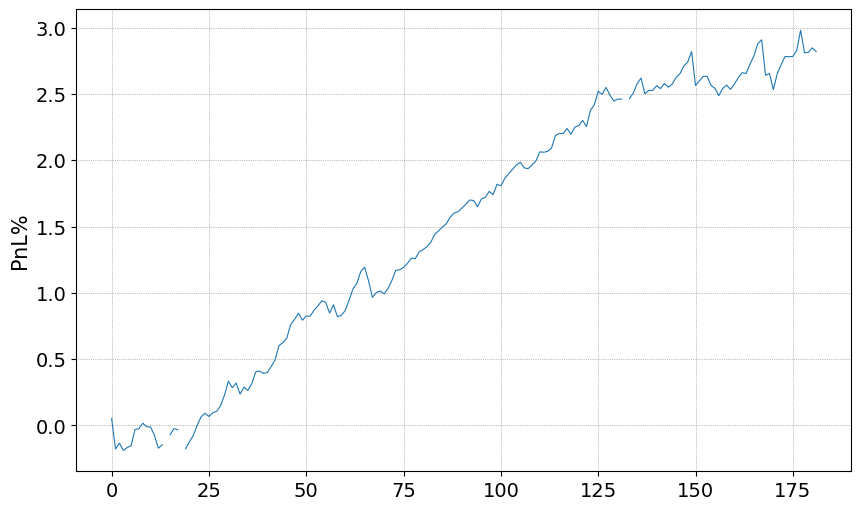

In [775]:
trs.set_index("entry_time").between_time(datetime.time(22), datetime.time(6)).pl.sub(2).cumsum().div(1e2).reset_index(drop=True).plot(ylabel="PnL%")

In [739]:
trs.set_index("entry_time").between_time(datetime.time(0), datetime.time(6)).pl.sub(2).resample("1d").sum().cumsum()

entry_time
2025-05-01 00:00:00+00:00     -2.322954
2025-05-02 00:00:00+00:00     29.418538
2025-05-03 00:00:00+00:00     22.867664
2025-05-04 00:00:00+00:00     67.411195
2025-05-05 00:00:00+00:00    120.280053
2025-05-06 00:00:00+00:00    193.327062
2025-05-07 00:00:00+00:00    246.820760
2025-05-08 00:00:00+00:00    239.147611
2025-05-09 00:00:00+00:00    272.951352
2025-05-10 00:00:00+00:00    291.417586
2025-05-11 00:00:00+00:00    293.167278
2025-05-12 00:00:00+00:00    278.624603
2025-05-13 00:00:00+00:00    307.556012
2025-05-14 00:00:00+00:00    352.183348
2025-05-15 00:00:00+00:00    350.259913
2025-05-16 00:00:00+00:00    337.316086
2025-05-17 00:00:00+00:00    349.658784
Freq: D, Name: pl, dtype: float64

### Coincheck